In [23]:
import pandas as pd
import numpy as np
import xgboost as xgb
# from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
import os
import copy
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [24]:
# Save the train and test DataFrames

PREPROCESS_DIR = "processed_data/glcm/"
X_TRAIN_DIR = PREPROCESS_DIR + "X_train.pkl"
y_TRAIN_DIR = PREPROCESS_DIR + "y_train.pkl"
X_TEST_DIR = PREPROCESS_DIR + "X_test.pkl"
y_TEST_DIR = PREPROCESS_DIR + "y_test.pkl"

X_train = joblib.load(X_TRAIN_DIR)
y_train = pd.read_pickle(y_TRAIN_DIR)
X_test = pd.read_pickle(X_TEST_DIR)
y_test = pd.read_pickle(y_TEST_DIR)




In [25]:
X_train

,contrast_d1_a0,contrast_d1_a0.7853981633974483,contrast_d1_a1.5707963267948966,contrast_d2_a0,contrast_d2_a0.7853981633974483,contrast_d2_a1.5707963267948966,contrast_d3_a0,contrast_d3_a0.7853981633974483,contrast_d3_a1.5707963267948966,dissimilarity_d1_a0,...,y_skew,x_kurtosis,y_kurtosis,glcm_mean,shd_dist1_dir1,shd_dist1_dir2,shd_dist1_dir3,prom_dist1_dir1,prom_dist1_dir2,prom_dist1_dir3
0,177.783072,8.223753,0.272827,0.165757,0.968539,0.027475,297.430799,10.748792,0.245486,0.160072,...,0.007194,2.009662,1.896919,18.250708,4.784799e+07,4.946932e+07,4.680497e+07,1.249516e+10,1.287475e+10,1.224099e+10
1,396.158462,12.603802,0.230600,0.157574,0.967524,0.024830,655.041704,16.629786,0.213508,0.154089,...,0.074640,1.975310,1.932083,19.071022,1.668901e+08,1.704196e+08,1.625122e+08,6.384172e+10,6.498358e+10,6.216693e+10
2,345.529028,12.307171,0.238930,0.165130,0.968250,0.027268,545.579795,15.410374,0.219580,0.158783,...,-0.000063,1.999626,1.953345,18.321593,1.272682e+08,1.322923e+08,1.245953e+08,4.631719e+10,4.800118e+10,4.539574e+10
3,287.623451,9.922127,0.255265,0.160253,0.962538,0.025681,436.259231,12.855893,0.229888,0.154968,...,-0.055772,2.013545,1.962250,18.906336,8.524542e+07,8.810263e+07,8.418482e+07,2.595670e+10,2.674941e+10,2.566126e+10
4,312.000638,11.654327,0.236421,0.158486,0.975516,0.025118,589.377907,15.842767,0.215629,0.152594,...,0.040579,1.955352,1.900882,19.078750,1.712434e+08,1.776251e+08,1.670757e+08,6.694403e+10,6.923703e+10,6.534362e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4124,296.518162,10.862258,0.236017,0.152198,0.975313,0.023164,555.103917,15.319699,0.209712,0.147373,...,0.057822,1.968125,1.932727,19.824304,1.885681e+08,1.945525e+08,1.835131e+08,7.227613e+10,7.431489e+10,7.028847e+10
4125,342.557965,12.203049,0.228426,0.153617,0.972161,0.023598,609.839934,16.129141,0.212036,0.148591,...,0.131674,1.971660,1.917816,19.655057,1.741305e+08,1.797563e+08,1.697855e+08,6.695057e+10,6.889975e+10,6.528664e+10
4126,355.140447,11.792915,0.237928,0.152600,0.970891,0.023287,633.553276,16.275083,0.215313,0.147693,...,0.060607,1.954471,1.894453,19.795361,1.695321e+08,1.748043e+08,1.655580e+08,6.526340e+10,6.703786e+10,6.368383e+10
4127,378.671275,12.567797,0.224769,0.150808,0.968889,0.022743,677.637930,17.019954,0.204249,0.147461,...,0.062477,1.961901,1.860322,19.921335,1.796878e+08,1.832785e+08,1.745383e+08,6.895293e+10,7.005235e+10,6.697519e+10


## Feature Selection // Removing highly correlated columns

In [26]:
# # If feature selection
# FEATURE_SELECTION = "processed_data/ft/"
# FT_FILE = "xgb_ft_jiaxu.pkl"

# import joblib

# CURRENT_DIRECTORY = os.getcwd()
# FEATURE_SORTED = joblib.load(FEATURE_SELECTION + FT_FILE)
# NUM_FEAT = 30
# FEATURES = FEATURE_SORTED[:NUM_FEAT]
# print(FEATURES)

# X_train = X_train[FEATURES]
# X_test = X_test[FEATURES]

print("Old")
print(X_test.shape)
print(X_train.shape)

Old
(1030, 67)
(4129, 67)


In [27]:
# low_corr_cols = joblib.load("processed_data\\ft\\low_corr_cols.pkl")

# X_train = X_train[low_corr_cols]
# X_test = X_test[low_corr_cols]

# print("After Removing Correlated Columns")
# print(X_test.shape)
# print(X_train.shape)

## SMOTE 

In [28]:
# print('Original dataset shape %s' % Counter(y_train))

# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# print('Resampled dataset shape %s' % Counter(y_train))

## SMOTEENN

In [29]:
# print('Original dataset shape %s' % Counter(y_train))
# sme = SMOTEENN(random_state=42)
# X_train, y_train = sme.fit_resample(X_train, y_train)

# print('Resampled dataset shape %s' % Counter(y_train))

## Data

In [30]:
data = {'X_train': X_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_train': y_train}

## Modelling
Models available: Plain_rf, Rf_op, Plain_xgb, xgb_op

In [31]:
def evaluate(y_test, y_pred):
    results = {
        'recall': recall_score(y_test, y_pred, average = 'weighted'),
        'precision': precision_score(y_test, y_pred, average = 'weighted'),
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred, average = 'weighted')
    }
    return results

def plain_rf(X_train, y_train, X_test, y_test, metric = "recall"):
    
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)

    pred = rf_model.predict(X_test)

    results = evaluate(y_test, pred)

    print(classification_report(y_test, pred))

    plot_cl(y_test, pred)

    return pred, results[metric]

def rf_op(X_train, y_train, X_test, y_test, metric = "recall"):

    def rf_trial(trial, final = False):
        param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt']),
        # 'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
        }

        model = RandomForestClassifier(**param)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        result = evaluate(y_test, preds)

        if final:
            print(classification_report(y_test, preds))
            plot_cl(y_test, preds)

            return preds, result[metric]
        

    study = optuna.create_study(direction = "maximize")
    study.optimize(rf_trial, n_trials = 100)

    model = study.best_trial
    model_copy = copy.deepcopy(model)

    pred, results = rf_trial(model_copy, final = True)

    return pred, results

def plain_xgb(X_train, y_train, X_test, y_test, metric = "recall"):
    """
    Perform XGBoost multiclass classification, evaluate the model, and create a confusion matrix.

    Parameters:
    X_train (torch.Tensor): Training features.
    y_train (torch.Tensor): Training labels.
    X_test (torch.Tensor): Testing features.
    y_test (torch.Tensor): Testing labels.

    Returns:
    None
    """
    
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    print(classification_report(y_test, pred))

    plot_cl(y_test, pred)

    results = evaluate(y_test, pred)

    return pred, results[metric]
    
    
def xgb_op(X_train, X_test, y_train, y_test, metric = 'accuracy'):
    

    def xgb_trial(trial, final = False):

        param = {
        'objective': 'multi:softmax',  # For multiclass classification
        'num_class': len(set(y_train)),  # Number of classes
        'eval_metric': 'mlogloss',  # Multiclass log loss
        'tree_method': 'hist',  # Faster training method
        'booster': 'gbtree',
        'verbosity': 0,
        'n_jobs': -1,
        'use_label_encoder': False,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-5, 1e3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e1),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),
        'n_estimators': 100
        }

        model = xgb.XGBClassifier(**param)

        model.fit(X_train, y_train)

        pred = model.predict(X_test)

        results = evaluate(y_test, pred)

        if final:
            print(classification_report(y_test, pred))
            plot_cl(y_test, pred)

            return pred, results[metric]

        return results[metric]

    study = optuna.create_study(direction = "maximize")
    study.optimize(xgb_trial, n_trials = 100)

    model = study.best_trial
    model_copy = copy.deepcopy(model)

    pred, results = xgb_trial(model_copy, final = True)

    return pred, results


def plot_cl(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels= set(y_test), yticklabels=set(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def roc_curve(y_test, y_pred):

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Calculate the Area Under the ROC Curve (AUC)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()



[I 2023-11-11 16:04:37,491] A new study created in memory with name: no-name-661c3516-802f-4d80-bc29-7faf326ca694
[I 2023-11-11 16:04:38,273] Trial 0 finished with value: 0.5349514563106796 and parameters: {'max_depth': 3, 'min_child_weight': 434.40300289119125, 'subsample': 0.9635987851018164, 'colsample_bytree': 0.7381156609285793, 'reg_alpha': 4.555444622877283, 'reg_lambda': 0.05153085854472149, 'learning_rate': 0.00354377174480032}. Best is trial 0 with value: 0.5349514563106796.
[I 2023-11-11 16:04:39,894] Trial 1 finished with value: 0.6097087378640776 and parameters: {'max_depth': 5, 'min_child_weight': 0.03398736749894668, 'subsample': 0.5514742964315136, 'colsample_bytree': 0.8960048365867396, 'reg_alpha': 0.6292061717338402, 'reg_lambda': 4.995543843514994, 'learning_rate': 0.003331423596120727}. Best is trial 1 with value: 0.6097087378640776.
[I 2023-11-11 16:04:42,923] Trial 2 finished with value: 0.7533980582524272 and parameters: {'max_depth': 7, 'min_child_weight': 0.79

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       511
           1       0.75      0.78      0.77       358
           2       0.83      0.59      0.69       151
           3       1.00      0.40      0.57        10

    accuracy                           0.80      1030
   macro avg       0.85      0.67      0.72      1030
weighted avg       0.81      0.80      0.80      1030



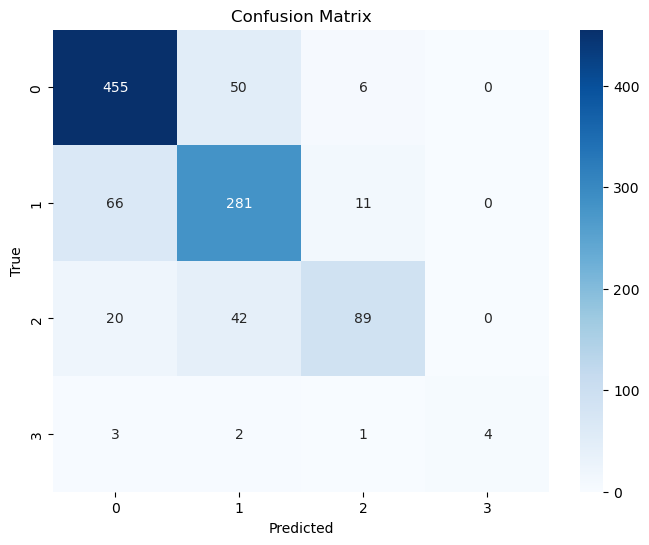

In [32]:
y_pred, results = xgb_op(**data)